# **FILTERING DATA FOR OPEN CLUSTER M67 TO DETERMINE CLUSTER MEMBER AND CALCULATE THE AGE OF THE OPEN CLUSTER USING ISOCHRONE METHOD** 

---

## 1. Introduction

<p align = "justify"> Star clusters have long been regarded as powerful tools for astronomers. It is often used by astronomers
to determine the distance an object is away from us. Star clusters have also been long thought to be
precursors to modern galaxies. Thus studying them can yield a better understanding of the formation of
galaxies as well as their evolution. </p>

<p align = "justify">
The oldest star clusters are also used sometimes to gauge limits on the age and the evolution history of
the universe. This is because many are formed close to the beginning of the universe. Thus star clusters
are studied extensively in cosmology to verify the accuracy of our cosmological models of the universe. </p>

<p align = "justify">
In order to study star clusters, we first need to determine which stars are in that cluster itself. This is
usually done using a clustering algorithm. In broad strokes, clustering algorithms assign stars into clusters.
Should the algorithm identify multiple clusters within the area of sky specified, the cluster with the most
members is defined as the star cluster. This method is often done using information from big surveys like
the Gaia mission. Such datasets usually include parameters such as the star’s proper motion, photometric
magnitudes, their position relative to stars with similar right ascension and declination.
</p>


## 2. Objectives

<p align = "justify"> Aims of this question are to:
<ol type="1">
<li>Filter the data for stars that belong to the cluster M67; and
<li>Determine the age of the cluster by using MISE isochrone fitting method.
</ol>
</p>

## 3. Theoretical Background

<p align = "justify"> The Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) is one of the
methods used by astronomers to determine if a particular star is in a cluster. This method is a variation
of an algorithm called Friend of Friends (FOF) which decides that a star is in the cluster if the star is
within a certain "distance" away from another star already in the cluster. The value of this "distance" is
usually called the linking length. </p>


**(a)What are the astrometric parameters you should consider when determining the linking length? Specify 3 such factors. (2 marks)**





## 4. Data

<p align = "justify"> The data that will be used is from Gaia Early Data Release 3 ("Gaia eDR3"). This release from the ESA
Gaia space mission is by far the deepest and most precise astrometric catalogue ever obtained.
</p>

<p align = "justify"> The data you need is already downloaded in the code folder. You do not need to download any other
data. The dataset contains data within 180 arcmins from the cluster center. Next, we select the sources
that satisfy the following criteria:
<ol type="1">
<li>Each source must have the five astrometric parameters, positions, proper motions, and parallax as
well as valid measurements in the three photometric passbands G, GBP , and GRP in the Gaia eDR3
catalogue;</li>
<li>Each source’s parallax value must be non-negative; and</li>
<li>The errors in each source’s G-mag must be less than 0.005.</li>
</ol>
</p>



**(b) Why are the above conditions necessary to ensure that the clustering of stars can be
done properly? (3 marks)**





### Part 1: Determine the Center of the Open Cluster

To determine the membership of open cluster M67, we will use a module in python called [hdbscan](https://hdbscan.readthedocs.io/en/latest/) (McInnes et al. 2017). If this notebook is run on Google Collaborator, we need to first install some libraries.

Import the required packages

In [ ]:
!pip install hdbscan
import math
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline,interp1d
import hdbscan
from sklearn.preprocessing import StandardScaler
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy import interpolate
#from sklearn.mixture import GaussianMixture
import arviz as az
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from __future__ import print_function
from __future__ import print_function
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Astrochallenge')
open('read_mist_models.py','wb')
import read_mist_models


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Set some plotting configurations

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline



---


#### Data Preparation



Import data file

In [ ]:
FILENAME = "gaiaedr3_150_M67.csv"
datafile = pd.read_csv(FILENAME, delimiter=",") 
datafile

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,603712422876575360,135.110808,0.179466,10.726941,0.144282,0.286789,0.189191,1.515865,1.814069,-0.675509,...,1.200222,18.423365,394.940086,7.716585,18.847214,574.873237,6.093434,17.848965,NaN,NaN
1,603712427171528448,135.118378,0.223748,10.723134,0.181216,0.051501,0.257076,0.200335,6.170623,-5.506968,...,22.767496,15.028518,9540.077355,15.731504,15.389663,13160.737711,19.746544,14.449695,NaN,NaN
2,603712457236324224,135.121338,0.523702,10.738075,0.395677,-0.012734,0.626520,-0.020324,14.416777,4.077665,...,0.745875,20.152782,72.474297,6.497540,20.688082,138.347415,8.024095,19.395468,NaN,NaN
3,603712560315544576,135.130346,0.903004,10.744922,0.761642,0.781963,0.969796,0.806316,1.470843,-0.476772,...,0.728559,20.612862,44.232127,6.761984,21.224197,102.227884,8.291773,19.723972,NaN,NaN
4,603713041351907200,135.140797,0.335336,10.772432,0.245219,0.951278,0.423789,2.244700,8.649885,-8.469014,...,30.743560,16.465595,2937.308732,11.487564,16.668669,4254.577059,11.557065,15.675755,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115665,603622950118859520,135.003350,1.049273,10.782234,0.879750,0.584927,1.131570,0.516916,10.016977,-9.962210,...,0.874115,20.763254,46.211559,6.517455,21.176666,119.069104,11.354191,19.558397,NaN,NaN
115666,603623018837269632,134.996200,0.473971,10.786565,0.392199,-0.134166,0.499585,-0.268555,4.335729,-4.332591,...,0.802039,20.045258,93.905349,10.996089,20.406816,168.347676,7.198842,19.182377,NaN,NaN
115667,603623018837270016,134.986138,0.489632,10.790086,0.348764,1.001567,0.589709,1.698409,17.389887,-11.889237,...,0.666937,20.240751,41.277856,5.681590,21.299250,190.096579,7.743901,19.050459,NaN,NaN
115668,603623053197008512,134.998781,0.346450,10.791484,0.283039,0.518023,0.360595,1.436578,8.223231,0.620460,...,0.799754,19.531996,93.553167,7.192426,20.410896,274.355026,7.375343,18.652113,NaN,NaN


In [ ]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115670 entries, 0 to 115669
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   source_id                  115670 non-null  int64  
 1   ra                         115670 non-null  float64
 2   ra_error                   115670 non-null  float64
 3   dec                        115670 non-null  float64
 4   dec_error                  115670 non-null  float64
 5   parallax                   95584 non-null   float64
 6   parallax_error             95584 non-null   float64
 7   parallax_over_error        95584 non-null   float64
 8   pm                         95584 non-null   float64
 9   pmra                       95584 non-null   float64
 10  pmra_error                 95584 non-null   float64
 11  pmdec                      95584 non-null   float64
 12  pmdec_error                95584 non-null   float64
 13  phot_g_mean_flux           11

Handling the missing values:

(this step drops all the values in the columns labelled proper motion right ascension(pmra), proper motion declination(pmdec) and parallax, and drops the corresponding row as well.

In [ ]:
datafile.dropna(subset=['pmra', 'pmdec', 'parallax']).reset_index()

,index,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,0,603712422876575360,135.110808,0.179466,10.726941,0.144282,0.286789,0.189191,1.515865,1.814069,...,1.200222,18.423365,394.940086,7.716585,18.847214,574.873237,6.093434,17.848965,NaN,NaN
1,1,603712427171528448,135.118378,0.223748,10.723134,0.181216,0.051501,0.257076,0.200335,6.170623,...,22.767496,15.028518,9540.077355,15.731504,15.389663,13160.737711,19.746544,14.449695,NaN,NaN
2,2,603712457236324224,135.121338,0.523702,10.738075,0.395677,-0.012734,0.626520,-0.020324,14.416777,...,0.745875,20.152782,72.474297,6.497540,20.688082,138.347415,8.024095,19.395468,NaN,NaN
3,3,603712560315544576,135.130346,0.903004,10.744922,0.761642,0.781963,0.969796,0.806316,1.470843,...,0.728559,20.612862,44.232127,6.761984,21.224197,102.227884,8.291773,19.723972,NaN,NaN
4,4,603713041351907200,135.140797,0.335336,10.772432,0.245219,0.951278,0.423789,2.244700,8.649885,...,30.743560,16.465595,2937.308732,11.487564,16.668669,4254.577059,11.557065,15.675755,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95579,115665,603622950118859520,135.003350,1.049273,10.782234,0.879750,0.584927,1.131570,0.516916,10.016977,...,0.874115,20.763254,46.211559,6.517455,21.176666,119.069104,11.354191,19.558397,NaN,NaN
95580,115666,603623018837269632,134.996200,0.473971,10.786565,0.392199,-0.134166,0.499585,-0.268555,4.335729,...,0.802039,20.045258,93.905349,10.996089,20.406816,168.347676,7.198842,19.182377,NaN,NaN
95581,115667,603623018837270016,134.986138,0.489632,10.790086,0.348764,1.001567,0.589709,1.698409,17.389887,...,0.666937,20.240751,41.277856,5.681590,21.299250,190.096579,7.743901,19.050459,NaN,NaN
95582,115668,603623053197008512,134.998781,0.346450,10.791484,0.283039,0.518023,0.360595,1.436578,8.223231,...,0.799754,19.531996,93.553167,7.192426,20.410896,274.355026,7.375343,18.652113,NaN,NaN


To eliminate sources with high uncertainties and to retain a fraction of the sources down to G ∼ 21 mag,
we need to select the sources with G-mag errors of less than 0.005. The calculated errors of G ($|\sigma_G|$), G$_{BP}$ ($|\sigma_{BP}|$), and G$_{RP}$ ($|\sigma_{RP}|$) are given by:
\begin{eqnarray}
|\sigma_G| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_G}}{F_G} \\
|\sigma_{BP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{BP}}}{F_{BP}} \\
|\sigma_{RP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{RP}}}{F_{RP}}
\end{eqnarray}

 **(c) Given the general formula for the error in the expression y = f(x) for some function f(x) is:**

\begin{eqnarray}
|\sigma_y| = \frac{df(x)}{dx} \sigma_x 
\end{eqnarray}

**show that the expression given above are the errors associated with the G band, BP band and RP band from the errors of their respective fluxes. (3 marks)**





Adding 4 more columns named e_Gmag, e_BPmag, e_RPmag and bp_rp (to plot color-magnitude easily), where e_Gmag, e_BPmag and e_RPmag are the errors for the magnitude of these bands.

In [ ]:
datafile['e_Gmag'] = abs(-2.5*datafile['phot_g_mean_flux_error']/math.log(10)/datafile['phot_g_mean_flux'])
datafile['e_BPmag'] = abs(-2.5*datafile['phot_bp_mean_flux_error']/math.log(10)/datafile['phot_bp_mean_flux'])
datafile['e_RPmag'] = abs(-2.5*datafile['phot_rp_mean_flux_error']/math.log(10)/datafile['phot_rp_mean_flux'])
datafile['bp_rp'] = datafile['phot_bp_mean_mag'] - datafile['phot_rp_mean_mag']


Select data with positive parallax value ($\omega>0$) and error of G magnitude ($\sigma_G$) $< 0.005$.

In [ ]:
pprocessdata = datafile[(datafile['parallax'] > 0) & (datafile['e_Gmag'] < 0.005)].reset_index(drop=True)
pprocessdata

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,...,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error,e_Gmag,e_BPmag,e_RPmag,bp_rp
0,603712422876575360,135.110808,0.179466,10.726941,0.144282,0.286789,0.189191,1.515865,1.814069,-0.675509,...,18.847214,574.873237,6.093434,17.848965,NaN,NaN,0.001620,0.021214,0.011508,0.998249
1,603712427171528448,135.118378,0.223748,10.723134,0.181216,0.051501,0.257076,0.200335,6.170623,-5.506968,...,15.389663,13160.737711,19.746544,14.449695,NaN,NaN,0.001347,0.001790,0.001629,0.939968
2,603715588267458176,135.105567,0.031968,10.754417,0.023291,0.644799,0.041918,15.382290,8.081793,-0.661945,...,15.448242,10779.170921,9.873325,14.666432,NaN,NaN,0.000280,0.001505,0.000994,0.781810
3,603715618332282624,135.119952,0.312882,10.770758,0.246001,1.459228,0.360624,4.046393,9.155590,-8.466374,...,20.016289,293.282890,7.710674,18.579680,NaN,NaN,0.002747,0.071853,0.028545,1.436609
4,603715622627196288,135.120392,0.016787,10.761850,0.012744,2.166628,0.020867,103.832520,15.660868,-15.391311,...,14.245265,37084.941878,30.516487,13.324902,NaN,NaN,0.000179,0.000717,0.000893,0.920363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70360,603622847038577280,134.983284,0.238657,10.768340,0.175209,0.577788,0.297446,1.942501,6.121636,-4.914994,...,19.841171,272.376897,6.706917,18.659970,NaN,NaN,0.002581,0.043561,0.026735,1.181201
70361,603622881398315520,134.968256,0.477930,10.767039,0.351956,0.068398,0.615982,0.111038,1.294598,-0.312259,...,21.146313,196.936992,5.951191,19.012077,NaN,NaN,0.004794,0.113976,0.032810,2.134236
70362,603622881398315776,134.965021,0.359085,10.770651,0.256683,0.671293,0.436031,1.539552,3.556748,-3.469882,...,20.838999,268.732655,5.201385,18.674595,NaN,NaN,0.003475,0.101277,0.021015,2.164404
70363,603623018837270016,134.986138,0.489632,10.790086,0.348764,1.001567,0.589709,1.698409,17.389887,-11.889237,...,21.299250,190.096579,7.743901,19.050459,NaN,NaN,0.004799,0.149444,0.044229,2.248791


Select pmra, pmdec and parallax for plotting

In [ ]:
df = pprocessdata[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)



---


####Visualization I 

Spatial Distribution

We start by looking at the Right Ascension [RA] ($\alpha$) and Declination ($\delta$) for each star. We will plot each star based on their RA and Declination on a graph to see where all the stars are located in the region of the sky we are interested in.

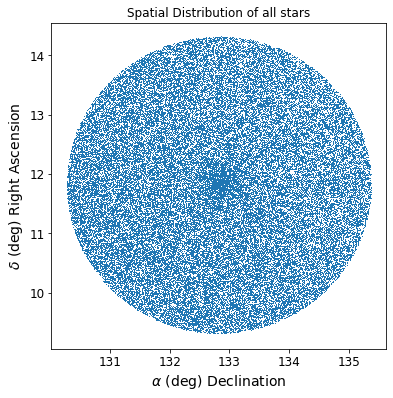

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(pprocessdata['ra'], pprocessdata['dec'], ',')

plt.xlabel(r'$\alpha$ (deg) Declination')
plt.ylabel(r'$\delta$ (deg) Right Ascension')
plt.title ('Spatial Distribution of all stars')

plt.show()

Vector Point Diagram

Now we know where the stars are, we want to see how each star moves across the night sky by studying its Proper Motion. To visualise this, we first break down the star's proper motion into the RA and Declination components. Thereafter, we plot each star on the diagram, where the x and y coordinate of the plotted point is given by the value of the star's proper motion in the RA and Declination directions respectively.

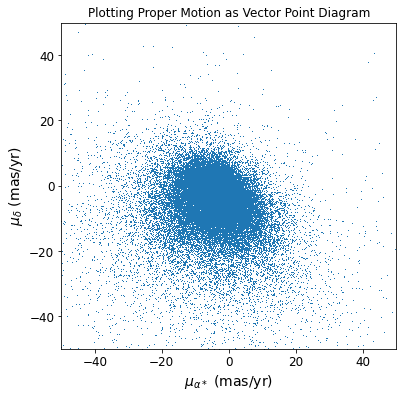

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(pprocessdata['pmra'], pprocessdata['pmdec'], ',')

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.title ('Plotting Proper Motion as Vector Point Diagram')

plt.ylim(-50,50)
plt.xlim(-50,50)

plt.show()

Color Magnitude Diagram

In [ ]:
df1=pd.DataFrame(pprocessdata[["phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag"]])
df1.to_excel("M67_colour_magnitude_unfiltered.xlsx")

**(d) Plot a color magnitude diagram for this unfiltered data.
By explaining the features of a star cluster in a color magnitude diagram, determine if this
diagram is representative of a star cluster. (2 marks)**

**Note:you can also edit the code in the previous cell to plot the Color magnitude diagram in this notebook.**

Normalize the data and run HDBSCAN

In [ ]:
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)
clus_size = 2 * df_.shape[1]
clusterer = hdbscan.HDBSCAN(clus_size)
cluster_labels = clusterer.fit_predict(df_)

pprocessdata['hdbscan'] = cluster_labels

Vector Point Diagram for every HDBSCAN cluster

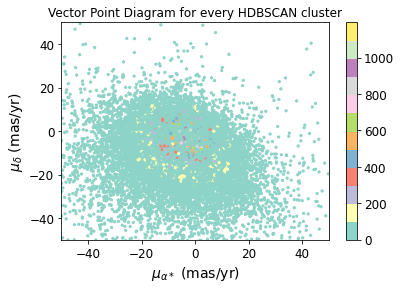

In [ ]:
fig, ax = plt.subplots()#figsize=(6,6))
plot = ax.scatter(pprocessdata['pmra'], pprocessdata['pmdec'], s=5, c=pprocessdata['hdbscan'], cmap='Set3') #edgecolor='')

fig.colorbar(plot, ax=ax)
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.title('Vector Point Diagram for every HDBSCAN cluster')
plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.show()

Distribution of stars inside each cluster and the number of members from each clustering result.

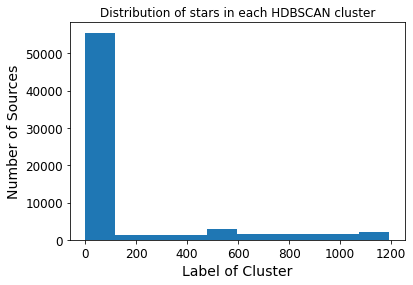

-1       54428
 539      1517
 682        85
 1153       69
 183        54
         ...  
 956         6
 170         6
 1141        6
 714         6
 447         6
Name: hdbscan, Length: 1196, dtype: int64

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(pprocessdata['hdbscan'])

plt.xlabel('Label of Cluster')
plt.ylabel('Number of Sources')
plt.title('Distribution of stars in each HDBSCAN cluster')

plt.show()
plt.close()

pprocessdata['hdbscan'].value_counts()

Separate the data with a label that shows the background data (`label = -1`).

In [ ]:
result_hdbscan = pprocessdata[pprocessdata['hdbscan'] >= 0].reset_index(drop=True)

c = result_hdbscan['hdbscan'].value_counts()
print (c)

539     1517
682       85
1153      69
183       54
1093      52
        ... 
956        6
170        6
1141       6
714        6
447        6
Name: hdbscan, Length: 1195, dtype: int64


Finding the cluster with the most number after assuming the data used only consists of the background and one stellar cluster.

In [ ]:
n_max = c.index[np.argmax(c)]

result = result_hdbscan[result_hdbscan['hdbscan'] == n_max]

In [ ]:
result

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error,e_Gmag,e_BPmag,e_RPmag,bp_rp,hdbscan
114,603785987076155392,134.065048,0.079601,10.469566,0.045647,1.005484,0.105191,9.558650,11.493557,-11.102049,...,1563.995273,8.818563,16.762306,NaN,NaN,0.000786,0.021069,0.006122,1.849257,539
365,603848521800034176,134.004906,0.020641,10.788134,0.011424,1.187326,0.027782,42.736748,11.663380,-11.295202,...,15319.236811,12.556026,14.284802,NaN,NaN,0.000201,0.001318,0.000890,0.936761,539
434,603864155480415104,133.969474,0.121766,10.945197,0.061010,1.280177,0.132631,9.652134,11.795609,-11.349657,...,1246.433959,8.483974,17.008722,NaN,NaN,0.001011,0.025902,0.007390,2.241158,539
552,603892330465906048,134.080464,0.170349,11.122002,0.092126,1.028626,0.227159,4.528219,12.030365,-11.586287,...,900.911109,8.206497,17.361190,NaN,NaN,0.001371,0.042503,0.009890,2.127190,539
890,604003037543393920,134.634072,0.294349,11.514641,0.211292,1.021565,0.347744,2.937690,11.927180,-11.450768,...,349.640117,6.705073,18.388842,NaN,NaN,0.002951,0.072723,0.020821,2.454822,539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,597743311687984768,133.498198,0.143220,10.020892,0.084263,1.389898,0.186031,7.471329,10.944349,-10.625956,...,811.327286,8.308019,17.474905,NaN,NaN,0.001391,0.043268,0.011118,2.180665,539
14987,597748259490474368,133.980939,0.064145,9.980416,0.035040,1.082202,0.086759,12.473657,10.979565,-10.467527,...,2202.649692,7.835871,16.390532,NaN,NaN,0.000671,0.009995,0.003862,1.653324,539
15007,597751935982497536,133.884114,0.070870,10.024290,0.032640,1.006440,0.095625,10.524891,10.981646,-10.715681,...,2306.038214,10.852281,16.340729,NaN,NaN,0.000691,0.012780,0.005110,1.669731,539
15307,597818907407813632,133.574190,0.437009,10.271831,0.222376,1.076692,0.600563,1.792805,11.574296,-11.357273,...,212.873595,6.234598,18.927591,NaN,NaN,0.003693,0.095295,0.031799,1.888819,539




---


####Visualization II (Result)

Spatial Distribution

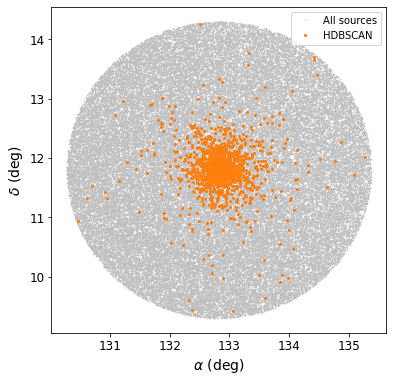

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.plot(pprocessdata['ra'], pprocessdata['dec'], '.', mec='silver', mfc='darkgray', markersize=1., label="All sources")
plt.plot(result['ra'], result['dec'], 'o', mfc='tab:orange', markersize=2., label="HDBSCAN")

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.legend()
plt.show()

Vector Point Diagram

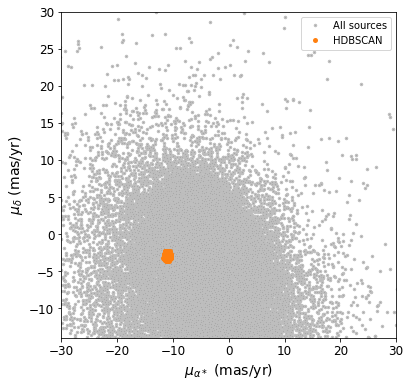

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(pprocessdata['pmra'], pprocessdata['pmdec'], '.', mec='silver', mfc='darkgray', markersize=5., label="All sources")
plt.plot(result['pmra'], result['pmdec'], 'o', mfc='tab:orange', mec='None', markersize=5., label="HDBSCAN")

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xticks()
plt.yticks()

plt.xlim(-30,30)
plt.ylim(-14,30)

plt.legend()
plt.show()

Color Magnitude Diagram

In [ ]:
df2=pd.DataFrame(result[["phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag"]])
df2.to_excel("M67_colour_magnitude_hdbfiltered.xlsx")

**(e)Plot a color magnitude diagram of this filtered data and explain what is/are the reason(s) for the differences in appearance between this and
the unfiltered data. (3 marks)**

Parallax Distribution

In [ ]:
bins_all = np.arange(pprocessdata['parallax'].min(), pprocessdata['parallax'].max(), .01)
bins_sam = np.arange(result['parallax'].min(), result['parallax'].max(), .01)

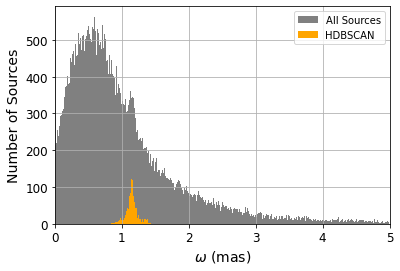

In [ ]:
plt.figure(figsize=(6, 4))
pprocessdata.parallax.hist(bins=bins_all, color='gray', label="All Sources")
result.parallax.hist(bins=bins_sam, color='orange', label="HDBSCAN")

plt.xlabel(r'$\omega$ (mas)')
plt.ylabel('Number of Sources')

plt.xlim(0, 5)

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

1. Determine the center of the stellar cluster

132.86004644209544 11.827238894818457 -10.962208193548145 -2.906340540074012 1.1534445059933707 866.9684538822082


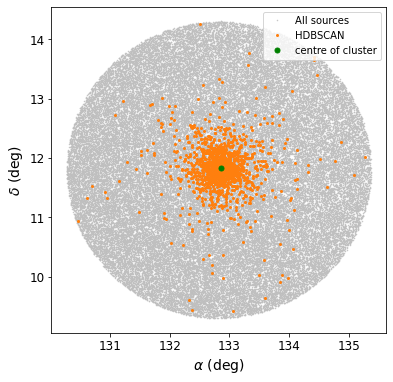

In [ ]:

ra_c    = np.mean(result['ra'])
dec_c   = np.mean(result['dec'])
pmra_c  = np.mean(result['pmra'])
pmdec_c = np.mean(result['pmdec'])

parallax_mean = np.mean(result['parallax'])
distance =1000/parallax_mean

print (ra_c, dec_c, pmra_c, pmdec_c, parallax_mean,distance)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.plot(pprocessdata['ra'], pprocessdata['dec'], '.', mec='silver', mfc='darkgray', markersize=1., label="All sources")
plt.plot(result['ra'], result['dec'], 'o', mfc='tab:orange', markersize=2., label="HDBSCAN")
plt.plot(ra_c,dec_c,'o', markersize=5, c= 'green', label='centre of cluster')
plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.legend()
plt.show()

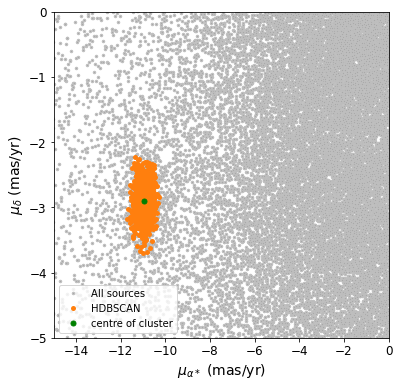

1517

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(pprocessdata['pmra'], pprocessdata['pmdec'], '.', mec='silver', mfc='darkgray', markersize=5., label="All sources")
plt.plot(result['pmra'], result['pmdec'], 'o', mfc='tab:orange', mec='None', markersize=5., label="HDBSCAN")
plt.plot(pmra_c,pmdec_c, 'o', markersize=5,c= 'green', label='centre of cluster')
plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xticks()
plt.yticks()

plt.xlim(-15,0)
plt.ylim(-5,0)

plt.legend()
plt.show()

len(result)

In [ ]:

y=result['phot_g_mean_mag']
x=result['bp_rp']
#plt.plot(x,y)

ya=y[x>0.5]
xa=x[x>0.5]

ya=ya+5-5*np.log10(distance)


In [ ]:
#@title Code from https://github.com/jieunchoi/MIST_codes/blob/master/scripts/read_mist_models.py
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

class ISO:
    
    """
    
    Reads in MIST isochrone files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso file.
        
        Usage:
            >> iso = read_mist_models.ISO('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso')
            >> age_ind = iso.age_index(8.0)
            >> logTeff = iso.isos[age_ind]['log_Teff']
            >> logL = iso.isos[age_ind]['log_L']
            >> plt.plot(logTeff, logL) #plot the HR diagram for logage = 8.0
            
        Attributes:
            version     Dictionary containing the MIST and MESA version numbers.
            abun        Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot         Rotation in units of surface v/v_crit.
            ages        List of ages.
            num_ages    Number of isochrones.
            hdr_list    List of column headers.
            isos        Data.
            
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.abun, self.rot, self.ages, self.num_ages, self.hdr_list, self.isos = self.read_iso_file()
        
    def read_iso_file(self):

        """
        Reads in the isochrone file.
        
        Args:
            filename: the name of .iso file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])
        
        #read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            iso = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3+counter+eep]
                iso[eep]=tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter+= 3+num_eeps+2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set  
        
    def age_index(self, age):
    
        """
        Returns the index for the user-specified age.
    
        Args:
            age: the age of the isochrone.
    
        """
    
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
    
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
        
        return age_index
    		
class ISOCMD:
    
    """
    
    Reads in MIST CMD files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso.cmd file.
        
        Usage:
            >> isocmd = read_mist_models.ISOCMD('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso.cmd')
            >> age_ind = isocmd.age_index(7.0)
            >> B = isocmd.isocmds[age_ind]['Bessell_B']
            >> V = isocmd.isocmds[age_ind]['Bessell_V']
            >> plt.plot(B-V, V) #plot the CMD for logage = 7.0
        
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            photo_sys       Photometric system. 
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            Av_extinction   Av for CCM89 extinction.
            rot             Rotation in units of surface v/v_crit.
            ages            List of ages.
            num_ages        Number of ages.
            hdr_list        List of column headers.
            isocmds         Data.
        
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.photo_sys, self.abun, self.Av_extinction, self.rot, self.ages, self.num_ages, self.hdr_list, self.isocmds = self.read_isocmd_file()
    
    def read_isocmd_file(self):

        """
        Reads in the cmd file.
        
        Args:
            filename: the name of .iso.cmd file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        photo_sys = ' '.join(content[2][4:])
        abun = {content[4][i]:float(content[5][i]) for i in range(1,5)}
        rot = float(content[5][-1])
        num_ages = int(content[7][-1])
        Av_extinction = float(content[8][-1])
        
        #read one block for each isochrone
        isocmd_set = []
        ages = []
        counter = 0
        data = content[10:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            isocmd = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                isocmd_chunk = data[3+counter+eep]
                isocmd[eep]=tuple(isocmd_chunk)
            isocmd_set.append(isocmd)
            ages.append(isocmd[0][1])
            counter+= 3+num_eeps+2
        return version, photo_sys, abun, Av_extinction, rot, ages, num_ages, hdr_list, isocmd_set

    def age_index(self, age):
        
        """
        Returns the index for the user-specified age.
        
        Args:
            age: the age of the isochrone.
        
        """
        
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
        
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
            
        return age_index

        
class EEP:
    
    """
    
    Reads in and plots MESA EEP files.
    
    """
    
    def __init__(self, filename, verbose=True):
        
        """
        
        Args:
            filename: the name of .track.eep file.
        
        Usage:
            >> eep = read_mist_models.EEP('00200M.track.eep')
            >> logTeff, center_h1, mdot = eep.eeps['log_Teff'], eep['center_h1'], eep['star_mdot']
            
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot             Rotation in units of surface v/v_crit.
            minit           Initial mass in solar masses.
            hdr_list        List of column headers.
            eeps            Data.
            
        """
                        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
                        
        self.version, self.abun, self.rot, self.minit, self.hdr_list, self.eeps = self.read_eep_file()
        
    def read_eep_file(self):
        
        """
        Reads in the EEP file.
        
        Args:
            filename: the name of .track.eep file.
                
        """
        
        eeps = np.genfromtxt(self.filename, skip_header=11, names=True)
        
        with open(self.filename) as f:
            content = [line.split() for line in f]

        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        minit = float(content[7][1])
        hdr_list = content[11][1:]
        
        return version, abun, rot, minit, hdr_list, eeps
        		
    def plot_HR(self, fignum=0, phases=[], phasecolor=[], **kwargs):
        
        """
        Plots the HR diagram.
        Args:
            None.
            
        Keywords:
            accepts matplotlib keywords: color, linestyle, linewidth, etc.
            keyword: fignum, phase*, phasecolor
            
            * Following the FSPS notation,
            * PMS:-1 ; MS:0 ; SGB+RGB:2 ; CHeB:3 ; EAGB:4 ; TPAGB:5 ; post-AGB:6 ; WR:9
    
        Usage:
            >> eep.plot_HR(fignum=3)
            >> eep.plot_HR(phase=[0, 2], phasecolor=['Gray', 'Blue']) #highlight the MS and RGB phases in gray and blue.
        
        """
        
        x = self.eeps['log_Teff']
        y = self.eeps['log_L']
        
        fig = plt.figure(fignum)
        plt.xlabel('log(Teff) [K]', fontsize=22)
        plt.ylabel('log(L/Lsun)', fontsize=22)
        
        ax = fig.add_subplot(111)
        ax.plot(x, y, **kwargs)
        ax.axis([max(x)+0.2, min(x)-0.2, min(y)-0.2, max(y)+0.2])

        if len(phases) >= 0:
            if len(phases) != len(phasecolor):
                print('The length of the phase and phasecolor array must be identical.')
                return
            for i_p, phase in enumerate(phases):
                p = self.eeps['phase']
                p_ind = np.where(p == phase)
                if len(p_ind) > 0:
                    if phasecolor == '':
                        ax.plot(x[p_ind], y[p_ind], linewidth=4.0, alpha=0.5)
                    else:
                        ax.plot(x[p_ind], y[p_ind], color=phasecolor[i_p], linewidth=4.0, alpha=0.5)

class EEPCMD:
    
    """
    
    Reads in and plots MESA EEP CMD files.
    
    """
    
    def __init__(self, filename, verbose=True):
        
        """
        
        Args:
            filename: the name of .track.eep.cmd file.
        
        Usage:
            >> eepcmd = read_mist_models.EEPCMD('00200M.track.eep.cmd')
            >> B, V, mdot = eepcmd.eepcmds['Bessell_B'], eep['Bessell_V'], eep['star_mdot']
            
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            photo_sys       Photometric system.
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot             Rotation in units of surface v/v_crit.
            minit           Initial mass in solar masses.
            hdr_list        List of column headers.
            Av_extinction   Av for CCM89 extinction.
            eepcmds         Data.
            
        """
                        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
                        
        self.version, self.photo_sys, self.abun, self.rot, self.minit, self.Av_extinction, self.hdr_list, self.eepcmds = self.read_eepcmd_file()
        
    def read_eepcmd_file(self):
        
        """
        Reads in the EEP CMD file.
        
        Args:
            filename: the name of .eep.cmd file.
                
        """
        
        eepcmds = np.genfromtxt(self.filename, skip_header=14, names=True)
        
        with open(self.filename) as f:
            content = [line.split() for line in f]

        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        photo_sys = ' '.join(content[2][4:])
        abun = {content[4][i]:float(content[5][i]) for i in range(1,5)}
        rot = float(content[5][-1])
        minit = float(content[8][1])
        Av_extinction = float(content[11][-1])
        hdr_list = content[14][1:]
        
        return version, photo_sys, abun, rot, minit, Av_extinction, hdr_list, eepcmds
        		
    def plot_CMD(self, filters, fignum=0, phases=[], phasecolor=[], **kwargs):
        
        """
        Plots the CMD diagram.
        Args:
            filters: a list of three filters, ['filter1', 'filter2', 'filter3']. x-axis: 'filter1'-'filter2', y-axis: 'filter3'
            
        Keywords:
            accepts matplotlib keywords: color, linestyle, linewidth, etc.
            keyword: fignum, phase*, phasecolor
            
            * Following the FSPS notation,
            * PMS:-1 ; MS:0 ; SGB+RGB:2 ; CHeB:3 ; EAGB:4 ; TPAGB:5 ; post-AGB:6 ; WR:9
    
        Usage:
            >> eepcmd.plot_CMD(['Bessell_B', 'Bessell_V', 'Bessell_V'], fignum=3)
        """
        
        try:
            x1 = self.eepcmds[filters[0]]
        except:
            print(filters[0]) + ' does not appear in this file.'
            return
        try:
            x2 = self.eepcmds[filters[1]]
        except:
            print(filters[1]) + ' does not appear in this file.'
            return
        try:
            y = self.eepcmds[filters[2]]
        except:
            print(filters[2]) + ' does not appear in this file.'
            return
        
        fig = plt.figure(fignum)
        plt.xlabel(' '.join(filters[0].split('_')) + '-' + ' '.join(filters[1].split('_')), fontsize=22)
        plt.ylabel(' '.join(filters[2].split('_')), fontsize=22)
        
        ax = fig.add_subplot(111)
        ax.plot(x1-x2, y, **kwargs)
        ax.axis([min(x1-x2)-0.2, max(x1-x2)+0.2, max(y)+0.2, min(y)-0.2])

        if len(phases) >= 0:
            if len(phases) != len(phasecolor):
                print('The length of the phase and phasecolor array must be identical.')
                return
            for i_p, phase in enumerate(phases):
                p = self.eepcmds['phase']
                p_ind = np.where(p == phase)
                if len(p_ind) > 0:
                    if phasecolor == '':
                        ax.plot(x1[p_ind]-x2[p_ind], y[p_ind], linewidth=4.0, alpha=0.5)
                    else:
                        ax.plot(x1[p_ind]-x2[p_ind], y[p_ind], color=phasecolor[i_p], linewidth=4.0, alpha=0.5)

In [ ]:
filename = 'MIST_iso_61cc17dfa05c7.iso.cmd'
iso = ISOCMD(filename)


Reading in: MIST_iso_61cc17dfa05c7.iso.cmd


<p align = "justify">We are now in a position to try fit our filtered data into a model of the star cluster. In this case we
use something called the isochrone model. This simulates a group of stars of different masses but with
the same chemical composition and age. By comparing the isochrone of different ages with the color
magnitude diagram of the cluster, we can determine the age of the cluster.
</p>

 **（f) Why is it that we use a group of stars with the same chemical composition but different
masses as a model for the star cluster? What does it suggest about the nature of stellar
formation? (2 marks)**



[0.67274]
0.3943459999999999


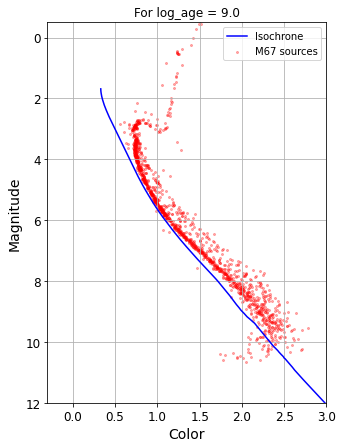

[0.851273]
0.44816300000000003


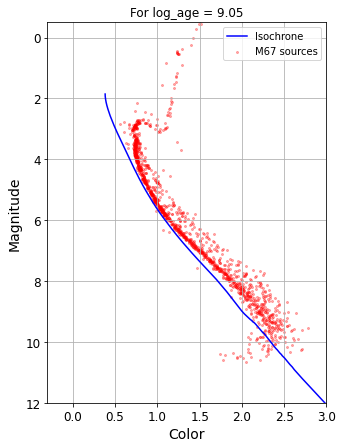

[1.035332]
0.5010859999999999


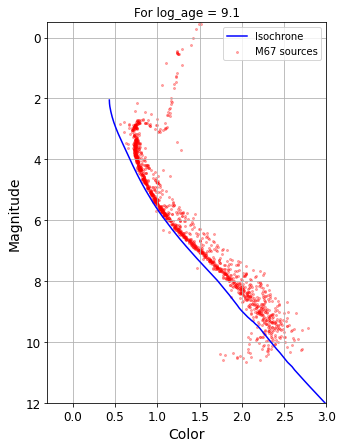

[1.221655]
0.5525530000000001


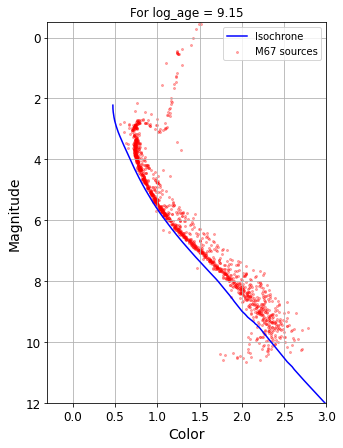

[1.406919]
0.6030519999999999


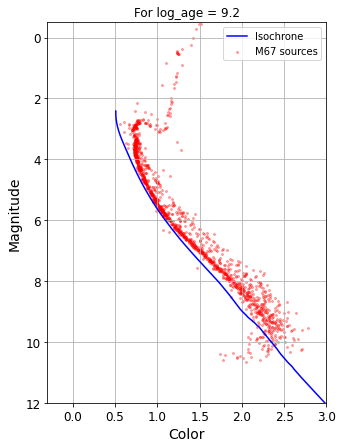

[1.593973]
0.6514109999999997


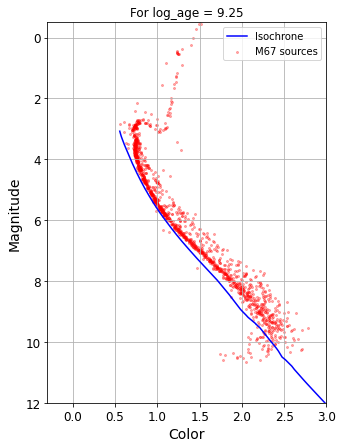

[1.779122]
0.6939329999999999


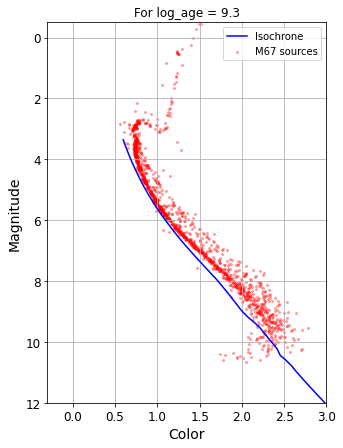

[1.963044]
0.7296639999999999


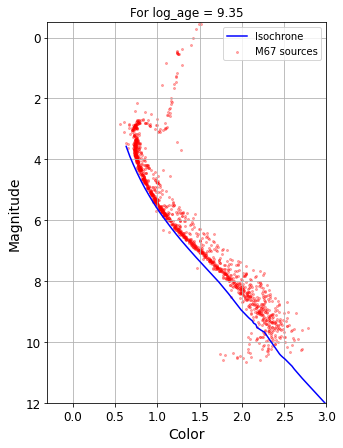

[2.143439]
0.7587769999999998


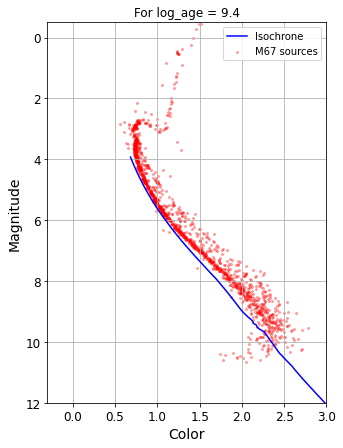

[2.322891]
0.7842879999999999


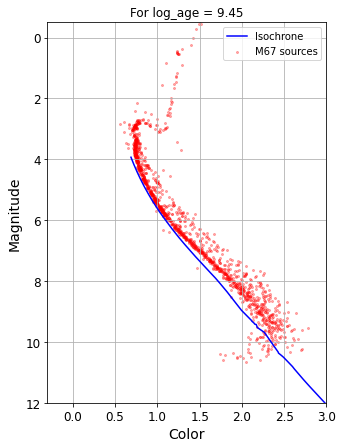

[2.499632]
0.8075909999999997


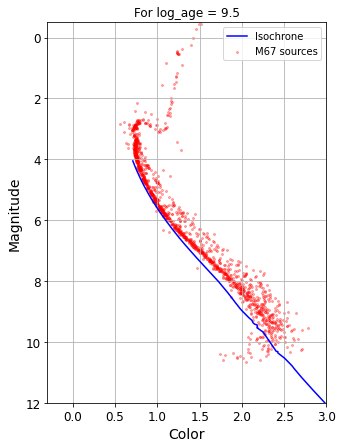

[2.672809]
0.8292050000000002


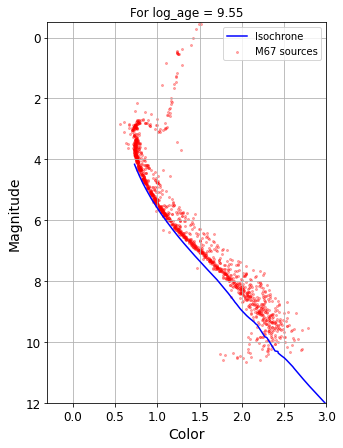

[2.84371]
0.849877


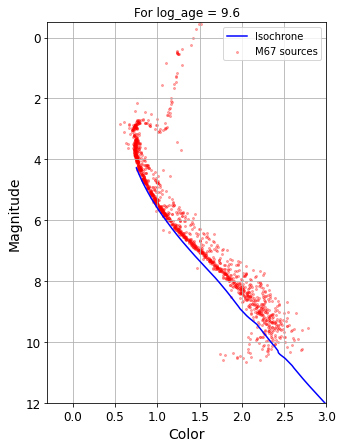

[3.016753]
0.8705940000000003


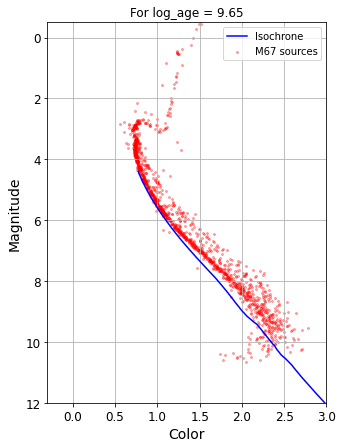

[3.196973]
0.8912419999999999


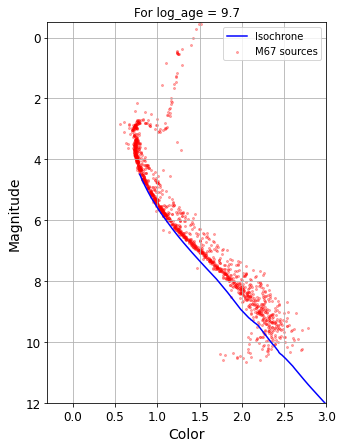

[3.394303]
0.9165509999999999


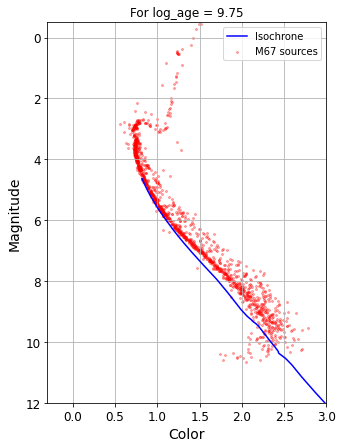

[3.547208]
0.9372619999999998


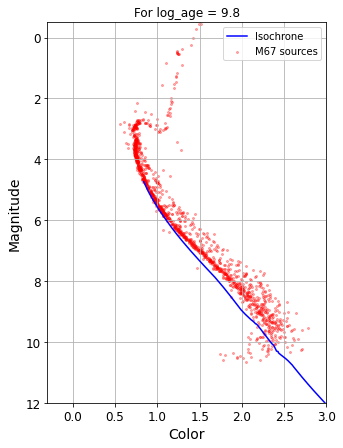

[3.774071]
0.9606399999999999


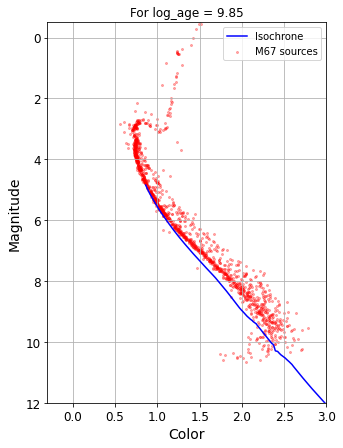

[3.889619]
0.980037


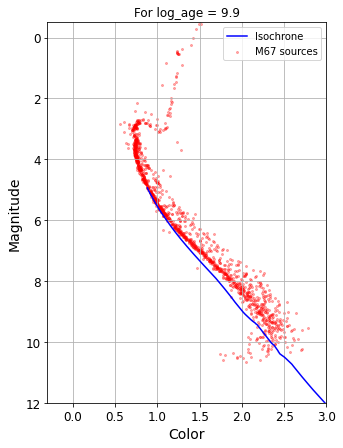

[3.99158]
0.9996020000000001


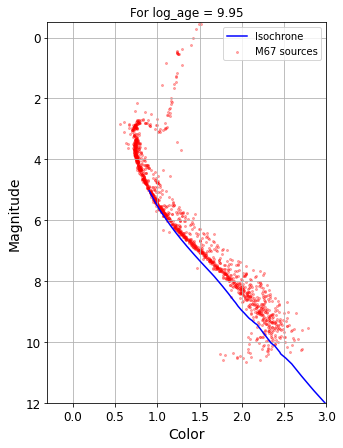

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


rmse_l=[]
age_range=np.arange(9.0,10.00,0.05)

for i in age_range:
    j=iso.age_index(i)
    
    iso_G=iso.isocmds[j]['Gaia_G_EDR3']
    iso_RP=iso.isocmds[j]['Gaia_RP_EDR3']
    iso_BP=iso.isocmds[j]['Gaia_BP_EDR3']
    
    B_R=iso_BP-iso_RP
  

    plt.figure(figsize=(5,7))
    

    ax=plt.gca()
    plt.ylim(-0.5,12)
    plt.xlim(-0.3,3)
    plt.scatter(xa,ya, color='red' , alpha=0.3, s=4, label="M67 sources")
   

    x1=B_R[iso_G>0]
    y1=iso_G[iso_G>0]
    y2=y1[x1>0]
    x2=x1[x1>0]
    ymin=y2[np.where(x2==x2.min())]
    print(ymin)
    cutoff=x2.min()+0.1
    print(x2.min()+0.2)
    ycutoff=ymin+1
    y3=y2[x2>cutoff]
    x3=x2[x2>cutoff]
    x4=x3[y3>ycutoff]
    y4=y3[y3>ycutoff]
    ## clearing up data for the best fit curve plotting  
    
    x=np.flip(x4)
    y=np.flip(y4)
    x.sort()
    y.sort()
  
    spl=CubicSpline(x,y)
    ##performing the best fit line fitting
 
    plt.plot(x,spl(x), c='blue', label="Isochrone")
    ##plot the best fit line as isochrone model

    ax.invert_yaxis()
    plt.xlabel("Color")
    plt.ylabel("Magnitude")
    plt.title("For log_age = " + str(round(i,2)))
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()



To determine how good the isochrone model fits with the star cluster, we measure the Residual Mean Square Error (RMSE) given by:
\begin{eqnarray}
\sigma&=\sqrt{\sum_{i=1}^n \frac{(x_\text{predicted}-x_\text{experimental})_i^2}{n}}
\end{eqnarray}
where $x_\text{predicted}$ is the predicted value of the variable（in this case the G band magnitude) from the isochrone model, and the $x_\text{experimental}$ is the observed data from the filtered star cluster data.


**(g) What does this RMSE value measure in terms of how good the model fits to the data?
How do the RMSE values of models which fit very well to the data compare to those that
do not fit very well? (2 marks)**

In [ ]:


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())



age_range=np.arange(9.0,10.00,0.01)

for i in age_range:
    j=iso.age_index(i)
    
    iso_G=iso.isocmds[j]['Gaia_G_EDR3']
    iso_RP=iso.isocmds[j]['Gaia_RP_EDR3']
    iso_BP=iso.isocmds[j]['Gaia_BP_EDR3']
    
    B_R=iso_BP-iso_RP
  



    x1=B_R[iso_G>0]
    y1=iso_G[iso_G>0]
    y2=y1[x1>0]
    x2=x1[x1>0]
    ymin=y2[np.where(x2==x2.min())]
    cutoff=x2.min()*1.2

    ycutoff=ymin+1
    y3=y2[x2>cutoff]
    x3=x2[x2>cutoff]
    x4=x3[y3>ycutoff]
    y4=y3[y3>ycutoff]
    ## clearing up data for the best fit curve plotting  
    
    x=np.flip(x4)
    y=np.flip(y4)

  
    x.sort()
    y.sort()
    spl=CubicSpline(x,y)
    d = {'experimental color index': xa, 'experimental magnitude':ya,'predicted magnitude':spl(xa) }
    df3=pd.DataFrame(d)
    df3.to_excel("M67_RMSE_age{:.03f}.xlsx".format(i))
    ##exporting model to excel file



  

**(h) The group of files entitled "M67_RMSE_age{age in log scale}.xlsx" should contain the model data and the experimental data for the same color index range for different different times of evolution of the
cluster. For isochrones of different ages, calculate the RMSE value using the formulae given
and determine the cluster age of which best fits the cluster.（3 marks）**

**Note: Please show the RMSE value obtained in your final submission.**

**Hint: If you are unable to code or are lost at this stage, note well that you do not have to
calculate the RMSE value for all the excel files in order to find the best fit value. Instead,
you should only pick a few key files to calculate the RMSE value and thereafter observe the
trend. If the best fit value seems to be between values X and Y, consider what could be
done to narrow the search. Particularly, you can choose to roughly calculate/estimate the
value of the best fit before looking through the excel files.**